## Setup the environment

In [1]:
from sys import executable
!{executable} -m pip install -U python-dotenv firebase-admin tqdm asyncio nest_asyncio aiohttp numpy matplotlib

     |████████████████████████████████| 112kB 3.8MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 102kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
     |████████████████████████████████| 256kB 15.2MB/s 
     |████████████████████████████████| 153kB 17.4MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=2010e766fc643b0f1b6c3351aee2b2cab347056b2f1e7ec41e24cc876dd066f4
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
  Found existing installation: firebase-admin 4.1.0
    Uninstalling firebase-admin-4.1.0:
      Successfully uninstalled firebase-admin-4.1.0
  Found existing installation: tqdm 4.41.1
    Uninstal

## Mount Google Drive if in Google Colab

In [0]:
from os import environ

In [3]:
IS_IN_COLAB = 'COLAB_GPU' in environ

if IS_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load .env configuration

Supposing that we have .env in parent folder (if run locally) or that we have prod.env and dev.env configuration files in Google Drive

In [0]:
from shutil import copyfile

In [5]:
while True:
    print("Please, specify the environment (prod/dev)")

    ENVIRONMENT = input()
    if ENVIRONMENT == 'prod' or ENVIRONMENT == 'dev':
        break

Please, specify the environment (prod/dev)
dev


In [0]:
# dotenv package does not work correctly with mouted storage, so moving .env to local directory
if IS_IN_COLAB:
    if ENVIRONMENT == 'dev':
        file_path = './drive/My Drive/dev.env'
    else:
        file_path = './drive/My Drive/prod.env'

    copyfile(file_path, './.env')

In [0]:
%reload_ext dotenv
%dotenv

from dotenv import dotenv_values
ENV = dotenv_values()

## Database initialization and queries

In [0]:
from pandas import DataFrame
from itertools import repeat

from firebase_admin import db, credentials, initialize_app

In [0]:
class Database():
    DEBUG_USER_IDS = [108431546, 120248031]

    def __init__(self, debug_user_ids=None):
        # Fetch the service account key JSON file contents
        creds = credentials.Certificate({
            'type': 'service_account',
            "token_uri": "https://accounts.google.com/o/oauth2/token",

            'project_id': ENV['FIREBASE_USERS_PROJECT_ID'],
            'client_email': ENV['FIREBASE_USERS_CLIENT_EMAIL'],
            'private_key': ENV['FIREBASE_USERS_PRIVATE_KEY'].replace('\\n', '\n'),
        })

        # Initialize the app with a service account, granting admin privileges
        initialize_app(creds, {
            'databaseURL': ENV['FIREBASE_USERS_URL']
        })
        
        # As an admin, the app has access to read and write all data, regradless of Security Rules
        self.users_db = db.reference('users').get()

        if debug_user_ids:
            self.DEBUG_USER_IDS = debug_user_ids

    def get_version(self):
        return db.reference('/').get()['version']

    def get_user_by_id(self, user_id, as_df=True):
        try:
            user = self.users_db[str(user_id)]
            if as_df:
                return DataFrame([user])
            return user
        except AttributeError as error:
            raise AttributeError(f"No user in database with id: {user_id}")
    
    def get_users_by_ids(self, user_ids, as_df=True):
        users = list(map(self.get_user_by_id, user_ids, repeat(False)))
        if as_df:
            return DataFrame(users)
        return users

    def get_user_by_username(self, username, as_df=True):
        for user in self.get_users_as_list():
            if 'username' in user and user['username'] == username:
                if as_df:
                    return DataFrame([user])
                return user
        raise AttributeError(f'No user with username: {username}')

    def get_users_by_usernames(self, usernames, as_df=True):
        users = list(map(self.get_user_by_username, usernames, repeat(False)))
        if as_df:
            return DataFrame(users)
        return users

    def get_all_chat_ids(self, debug=False):
        int_keys = list(map(int, self.users_db.keys()))
        if debug:
            return int_keys[1:5] + self.DEBUG_USER_IDS
        return int_keys

    def get_users_as_list(self, debug=False):
        users = list(self.users_db.values())
        if debug:
            return users[1:5] + [self.get_user_by_id(self.DEBUG_USER_IDS[0])]
        return users

In [0]:
database = Database()

In [11]:
database.get_version()

'v3'

In [12]:
database.get_user_by_id(database.DEBUG_USER_IDS[0])

,defaultPlatoon,first_name,id,is_bot,language_code,lastAccess,last_name,type,username
0,1707,Maxim,108431546,False,en,1591016696,Shmakov,private,mvshmakov


```python
df = database.get_users_by_ids(database.get_all_chat_ids())
df[df['lastAccess'].notna()]
```
This can show the amount of people with debug info in DataFrame

In [13]:
database.get_users_by_ids(database.DEBUG_USER_IDS)

,defaultPlatoon,first_name,id,is_bot,language_code,lastAccess,last_name,type,username
0,1707,Maxim,108431546,False,en,1591016696,Shmakov,private,mvshmakov
1,1801,Vasilisa,120248031,False,ru,1587837860,Diomina,private,le_bourbier


In [14]:
database.get_user_by_username('mvshmakov')

,defaultPlatoon,first_name,id,is_bot,language_code,lastAccess,last_name,type,username
0,1707,Maxim,108431546,False,en,1591016696,Shmakov,private,mvshmakov


In [15]:
database.get_users_by_usernames(['mvshmakov', 'egorka1397'])

,defaultPlatoon,first_name,id,is_bot,language_code,lastAccess,last_name,type,username
0,1707,Maxim,108431546,False,en,1591016696,Shmakov,private,mvshmakov
1,1606,Егор,94552162,False,ru,1587908646,Shirobokov,private,egorka1397


## Database dumps in Google Drive

Works both in the Colab and on every other machine (locally). Unfortunatelly, due to wordy Google Drive API implementation it is now required to do all the Google Drive synchronization (download/upload) manually. So, you still can use the listed API, but in slightly another way. For instance, you can create a snapshot of DB (it would be written to a local directory - './firebase-users-dumps/') and restore DB from an existing snaphot (you need to place a snapshot to the same directory).

In [0]:
import json

from os import listdir, makedirs
from os.path import isfile, join, isdir

from gzip import GzipFile
from datetime import datetime

In [0]:
class DatabaseBackuper():
    gz_postfix = '.json.gz'

    def __init__(self, db_instance):
        self.db = db_instance

        if IS_IN_COLAB:
            self.basedir = './drive/My Drive/firebase-users-dumps/'
        else:
            self.basedir = './firebase-users-dumps/'
        
        if not isdir(self.basedir):
            makedirs(self.basedir, exist_ok=True)

    def dump_db(self):
        try:
            filename = database.get_version() + '-users-' + datetime.utcnow().isoformat()
            path = self.basedir + filename + self.gz_postfix

            with GzipFile(path, 'w') as fout:
                fout.write(json.dumps(self.db.users_db).encode('utf-8'))

            print(f"Dump successfully written. File name: {path}")
        except Exception as exception:
            print('Error occured.', exception)

    def list_backups(self):
        if not IS_IN_COLAB:
            print(f"Download needed backups manually from Google Drive to '{self.basedir}' directory. Showing what we have locally:")

        return sorted([file for file in listdir(self.basedir) if file.endswith(self.gz_postfix)])

    def show_snapshot(self, snapshot_name):
         with GzipFile(self.basedir + snapshot_name, 'r') as fin:
            print(json.loads(fin.read().decode('utf-8')))

    def restore_db(self, backup_name):
        try:
            with GzipFile(self.basedir + backup_name, 'r') as fin:
                data = json.loads(fin.read().decode('utf-8'))
                version = backup_name[:2]
                snapshot_name = backup_name[:-len(self.gz_postfix)]

                print(f'Are you sure you want to use {snapshot_name} snapshot? (y/n)')
                answer = input()

                if answer == 'y':
                    db.reference('version').set(version)
                    db.reference('users').set(data)
                    print(f'Database is using the {snapshot_name} snapshot')
                else:
                    print('Database is using the same snapshot')

        except Exception as exception:
            print(f'Error happend. {exception}')

In [0]:
backuper = DatabaseBackuper(database)

In [19]:
backuper.dump_db()

Dump successfully written. File name: ./drive/My Drive/firebase-users-dumps/v3-users-2020-06-01T15:09:39.260069.json.gz


In [20]:
backups = backuper.list_backups()
DataFrame(backups, columns=['Backup name'])

,Backup name
0,v3-users-2020-05-05T16_37_01.409674.json.gz
1,v3-users-2020-05-05T16_43_38.380324.json.gz
2,v3-users-2020-05-05T16_43_58.853090.json.gz
3,v3-users-2020-05-06T17_09_59.605495.json.gz
4,v3-users-2020-05-06T19_27_23.570229.json.gz
5,v3-users-2020-06-01T15:09:39.260069.json.gz


In [0]:
# Or you can write something specific
backup_name = backups[-1]

# backuper.show_snapshot(backup_name)

In [22]:
backuper.restore_db(backup_name)

Are you sure you want to use v3-users-2020-06-01T15:09:39.260069 snapshot? (y/n)
n
Database is using the same snapshot


## Database analytics

In [0]:
import matplotlib.pyplot as plt

from numpy import arange
from numbers import Number

from functools import reduce
from operator import itemgetter

In [0]:
def users_stats(db_instance, show_chat_ids=False):
    def remove_without_data(lst, user):
        if 'lastAccess' in user:
            lst.append(user)
        return lst

    objects = ('Have', 'Don\'t have')
    y_pos = arange(len(objects))

    users = db_instance.get_users_as_list()
    with_data = reduce(remove_without_data, users, [])

    x_pos = [
        len(with_data),
        len(users) - len(with_data)
    ]

    plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
    plt.bar(y_pos[1], x_pos[1], color='red', align='center')

    plt.ylabel('Number of users')
    plt.xticks(y_pos, objects)
    plt.yticks(x_pos)
    plt.title('Number of users that have personal info')

    plt.show()

    chat_ids_with_data = list(map(
        lambda user: f"{user['id']} ({user['username']})" if 'username' in user else f"{user['id']} ({user['first_name']})",
        sorted(with_data, key=itemgetter('id'))))

    print(f"Total amount of users: {len(users)}")
    print(f"Percentage of users with personal info: {len(with_data) / len(users) * 100} %")

    if len(chat_ids_with_data) > 0 and show_chat_ids:
        print(f"Chat_ids with personal info: {', '.join(chat_ids_with_data)}")

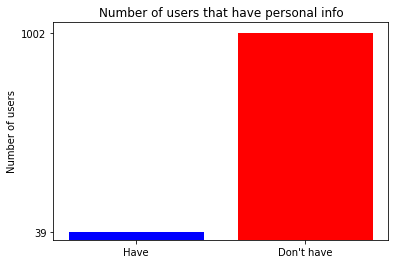

Total amount of users: 1041
Percentage of users with personal info: 3.7463976945244957 %
Chat_ids with personal info: 80713059 (Barin_Ildar), 94552162 (egorka1397), 108431546 (mvshmakov), 120248031 (le_bourbier), 128855625 (JustDoItTim), 145179757 (bogdanych), 174323714 (AnthonyTheTrader), 175030142 (N), 183082518 (DLDLU), 220016879 (xgenav), 236575546 (kalmykokiller), 250902923 (Sadrik78), 257765200 (xdownshiftx), 259070545 (EgorKrapivin), 259600937 (pvsemk), 283913176 (Korolkovo), 293969991 (Fenribel), 306703947 (Артём), 313741256 (Alexander), 333345635 (Bogdan_Beat), 335299756 (vvmosmvoretskiy), 339186680 (olpyhn), 339755055 (AHTOH4EK), 352468184 (Ksenia), 357328986 (ms_udalova), 372425574 (loveandhate88), 372861455 (Sde_or), 418191846 (chubsr), 432929300 (Nikolai), 433435866 (Елена), 440708994 (spacedog46471), 440778228 (chizhart), 487468704 (MikhailN25), 501641067 (NN_Nikita_Nikitov), 606701399 (Lubov), 760814802 (ilyaonoff), 776605027 (Dmitry), 1150268854 (Дмитрий), 1151088630 (L

In [25]:
users_stats(database, True)

## Database migrations

In [0]:
import json
from gzip import GzipFile

In [0]:
def migrate_v1_v2(database):
    new_users = {}

    for (id, user) in database.users_db.items():
        if 'platoon' in user:
            del user['platoon']
        if 'platoonType' in user:
            del user['platoonType']
        new_users[id] = user

    print(f'Are you sure you want to migrate from v1 to v2? (y/n)')
    answer = input()

    if answer == 'y':
        db.reference('users').set(new_users)
        db.reference('version').set('v2')
        print('Database merged data and is using v3 schema')
    else:
        print('Database is using the same version')

In [0]:
def migrate_v2_v3(database):
    with GzipFile(backuper.basedir + 'users-7.04.20-21:56:47.json.gz', 'r') as fin:
        old_data = json.loads(fin.read().decode('utf-8'))['users']

    # Old (v1) and new (v2) unified data processing
    new_users = {}
    for (id, user) in {**old_data,
                       **database.users_db}.items():
        new_users[id] = {}

        # Related to new data
        if 'debug' in user:
            new_users[id] = {
                **user['debug']['user'],
                'lastAccess': user['debug']['lastAccess']}
        if 'defaultPlatoon' in user:
            new_users[id].update({'defaultPlatoon': user['defaultPlatoon']})
        new_users[id].update({'id': int(id)})

    print(f'Are you sure you want to migrate from v2 to v3? (y/n)')
    answer = input()

    if answer == 'y':
        db.reference('users').set(new_users)
        db.reference('version').set('v3')
        print('Database merged data and is using v3 schema')
    else:
        print('Database is using the same version')

In [0]:
# migrate_v1_v2(database)
# migrate_v2_v3(database)

## Sending messages

In [0]:
import json
import asyncio

from aiohttp import ClientSession
from tqdm.notebook import tqdm

In [0]:
# Fix for ipython event loop
import nest_asyncio
nest_asyncio.apply()

In [0]:
class MessageSender():
    headers = {'content-type': 'application/json'}
    stats = {}

    def __init__(self, bot_token=ENV["BOT_TOKEN"]):
        self.url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    def show_stats(self):
        response = self.stats['response']
        if (response['ok'] != True):
            print(f"{response['description']}. Try again.")
        else:
            chat = response['result']['chat']
            if 'username' in chat:
                print(f"Message \'{response['result']['text']}\' sent to {chat['username']} ({chat['first_name']})")
            else:
                print(f"Message \'{response['result']['text']}\' sent to {chat['first_name']}")
            print(f"At: {self.stats['date']}, Chat ID: {chat['id']}")

    def send_msg_to_chat(self, chat_id, text):
        loop = asyncio.get_event_loop()

        async def send_msg_to_chat_async():
            async with ClientSession() as session:
                self.stats = await self.send_msg_to_chat_async(session, chat_id, text)

        loop.run_until_complete(send_msg_to_chat_async())

    async def send_msg_to_chat_async(self, session, chat_id, text):
        payload = json.dumps({
            'chat_id': chat_id,
            'text': text
        })

        async with session.post(self.url, data=payload, headers=self.headers) as response:
            text = await response.text()

            return {
                'date': response.headers.get("DATE"),
                'response': json.loads(text),
            }

In [0]:
MAX_PARALLEL = 500

class MultipleMessagesSender(MessageSender):
    stats = []

    def __init__(self, db_instance, bot_token=ENV["BOT_TOKEN"]):
        super().__init__(bot_token)
        self.db = db_instance
    
    def __stat_count_with_error(self, counter, user):
        if user['response']['ok'] == True:
            return counter
        return counter + 1

    def show_errors_rate(self):
        objects = ('Succeded', 'Errored')
        y_pos = arange(len(objects))

        with_error = reduce(self.__stat_count_with_error, self.stats, 0)
        print(f"Successful messages: {(1 - with_error / len(self.stats)) * 100} %")

        x_pos = [
            len(self.stats) - with_error,
            with_error,
        ]

        plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
        plt.bar(y_pos[1], x_pos[1], color='red', align='center')

        plt.ylabel('Number of requests')
        plt.yticks(x_pos)
        plt.xticks(y_pos, objects)
        plt.title('Number of succesful requests and errors')

        plt.show()

    def show_errors(self):
        if reduce(self.__stat_count_with_error, self.stats, 0) == 0:
            print('No errors!')
        else:
            def make_errors_map(errs, stat):
                if 'response' not in stat or 'description' not in stat['response']:
                    return errs
                description = stat['response']['description']
                if description in errs:
                    errs[description] += 1
                else:
                    errs[description] = 1
                return errs

            errors = reduce(make_errors_map, self.stats, {})

            x_pos = list(errors.values())
            y_pos = list(errors.keys())
            plt.bar(y_pos, x_pos, color='red', align='center')

            plt.ylabel('Number of errors')
            plt.yticks(x_pos)
            plt.xticks(y_pos, rotation=45)
            plt.title('Errors by description')

            plt.show()
            
    def show_problem_ids(self):
        if reduce(self.__stat_count_with_error, self.stats, 0) == 0:
            pass
        else:
            def get_problem_ids(ids, stat):
                if 'description' not in stat['response']:
                    return ids

                chat_id = stat['chat_id']
                if chat_id in ids:
                    return ids
                else:
                    ids.append(chat_id)
                    return ids

            failed_chat_ids = map(str, sorted(reduce(get_problem_ids, self.stats, [])))
            print(f"Problematic chat_ids: {', '.join(failed_chat_ids)}")

    def show_stats(self, show_problem_ids=False):
        self.show_errors_rate()
        self.show_errors()

        if show_problem_ids:
            self.show_problem_ids()

    def send_msg_to_everyone(self, text, parallel=MAX_PARALLEL):
        loop = asyncio.get_event_loop()
        future = asyncio.ensure_future(self.send_msg_to_everyone_async(text, parallel))
        loop.run_until_complete(future)

    async def bound_requests(self, session, semaphore, chat_id, text):
        # Getter function with semaphore.
        async with semaphore:
            return await self.send_msg_to_chat_async(session, chat_id, text)

    async def send_msg_to_everyone_async(self, text, debug=False, parallel=MAX_PARALLEL):
        tasks = []
        chat_ids = self.db.get_all_chat_ids(debug)
        semaphore = asyncio.Semaphore(parallel)

        # Create client session that will ensure we dont open new connection per each request.
        async with ClientSession() as session:
            for chat_id in chat_ids:
                task = asyncio.ensure_future(
                    self.bound_requests(session, semaphore, chat_id, text))
                tasks.append(task)

            for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
                await task

            results = await asyncio.gather(*tasks)
            
            def merge_stat_with_chat_id(accumulator, stat):
                stat[0]['chat_id'] = stat[1]
                accumulator.append(stat[0])
                return accumulator
                
            self.stats = list(reduce(merge_stat_with_chat_id, zip(results, chat_ids), []))

In [0]:
text = 'Привет, это новый бот! Вы можете выствить в настройках свой взвод, чтобы получать расписание в один клик!'
chat_id = database.DEBUG_USER_IDS[0]

In [35]:
sender = MessageSender()

if ENVIRONMENT == 'prod':
    print("Send a message? (y/n)")
    answer = input()
    if answer == 'y':
        sender.send_msg_to_chat(chat_id, text)
        sender.show_stats()
    else:
        print("Message is not sent")
else:
    sender.send_msg_to_chat(chat_id, text)
    sender.show_stats()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The object should be created from async function


Message 'Привет, это новый бот! Вы можете выствить в настройках свой взвод, чтобы получать расписание в один клик!' sent to mvshmakov (Maxim)
At: Mon, 01 Jun 2020 15:09:54 GMT, Chat ID: 108431546


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: DeprecationWarning: The object should be created from async function



Successful messages: 16.666666666666664 %


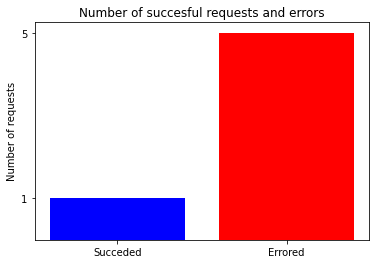

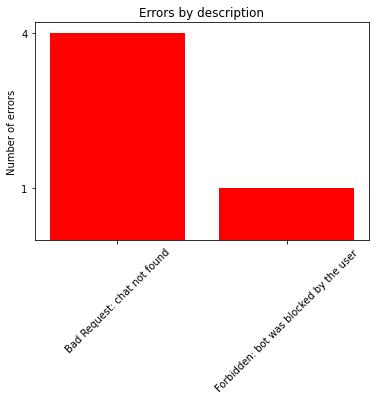

Problematic chat_ids: 565124, 733019, 947413, 1323215, 120248031


In [36]:
multiple_sender = MultipleMessagesSender(database)

if ENVIRONMENT == 'prod':
    print("Send messages? (y/n)")
    answer = input()
    if answer == 'y':
        multiple_sender.send_msg_to_everyone(text)
        multiple_sender.show_stats()
    else:
        print("Messages are not sent")
else:
    multiple_sender.send_msg_to_everyone(text, True)
    multiple_sender.show_stats(True)